In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import pickle
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [2]:
%%capture
from nilearn.datasets import fetch_abide_pcp

abide_data=fetch_abide_pcp(
                               pipeline="cpac",
                               derivatives=["rois_aal"],
                               band_pass_filtering=True,
                               data_dir="/home/comlab/Mahyar/Master_project_fMRI/AAL_atlas"
                               )


all_signals=[abide_data["rois_aal"][i][:,0:90] for i in range(len(abide_data["rois_aal"]))]

df_info=abide_data["phenotypic"][["SUB_ID","SITE_ID","DX_GROUP","AGE_AT_SCAN","SEX"]]
df_info.index=np.arange(len(df_info))
site_names=list(set(df_info["SITE_ID"]))

even_ind=np.arange(0,90,2)
odd_ind=np.arange(1,90,2)[::-1]
rearrange_arr=np.hstack((even_ind,odd_ind))

labels=np.array(pd.read_csv("/home/comlab/Mahyar/Master_project_fMRI/aal_labels.csv", skiprows=1).iloc[:,-1])[0:90]
labels=labels[rearrange_arr]

all_signals=[all_signals[i][:,rearrange_arr] for i in range(len(all_signals))]
num_rois=all_signals[0].shape[-1]
edge_ind=np.triu_indices(num_rois,k=1)

In [4]:
def MEM_estimator(binarized_signals, n_epochs=1000, eps=0.01):
    t_max=binarized_signals.shape[0]
    num_rois=binarized_signals.shape[-1]
    empirical_averages=binarized_signals.mean(axis=0)
    empirical_correlations=(binarized_signals.T@binarized_signals)/t_max
    J_error=[]
    h_error=[]
    #intial values
    #J=-np.linalg.inv(np.cov(binarized_signals.T))
    x=np.random.normal(0.3,1,size=int(num_rois*(num_rois-1)/2))
    edge_ind=np.triu_indices(num_rois,k=1)
    J=np.zeros((num_rois,num_rois))
    J[edge_ind]=x
    J=J+J.T
    h=np.random.normal(size=(num_rois))
    

    for i in range(n_epochs):

        model_averages=(np.tanh(np.tile(h, (t_max,1))+binarized_signals@J)).mean(axis=0)
        model_correlations=np.zeros((num_rois,num_rois))

        for t in range(t_max):
            model_correlations=model_correlations+binarized_signals[t,:].reshape(-1,1)@np.tanh(
                (h+J@binarized_signals[t,:]).reshape(1,-1)
            )

        model_correlations=model_correlations/t_max

        delta_h=empirical_averages-model_averages
        h=h+eps*delta_h
        delta_J=empirical_correlations-model_correlations
        J=J+eps*delta_J
        np.fill_diagonal(J,0)
        np.fill_diagonal(delta_J,0)
        J=(J+J.T)/2
        #J_error.append(np.abs(delta_J[edge_ind]).sum())
        #h_error.append(np.abs(delta_h).sum())

    
        
    return (h,J,np.abs(delta_h).sum()/num_rois,np.abs(delta_J[edge_ind]).sum()/len(edge_ind[0]))

In [3]:
#preprocessing and binarizing

#healthy_signals={}
#autistic_signals={}
binarized_signals=[]

for i,signal in enumerate(all_signals):
    mean_signal=signal.mean()
    signal=signal-mean_signal
    signal[signal<0]=-1
    signal[signal>0]=1

    binarized_signals.append(signal)

In [140]:
#binary spin model !!!

#to see the difference between naive MEM model and partial correlation

from nilearn.connectome import ConnectivityMeasure

s0=binarized_signals[0]
s0_connectome = ConnectivityMeasure(kind='partial correlation')
correlation_matrix = s0_connectome.fit_transform([s0])[0]
np.fill_diagonal(correlation_matrix,0)

mem_s0=MEM_estimator(binarized_signals[0])

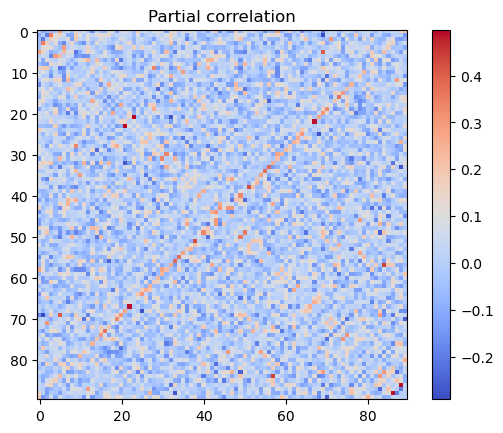

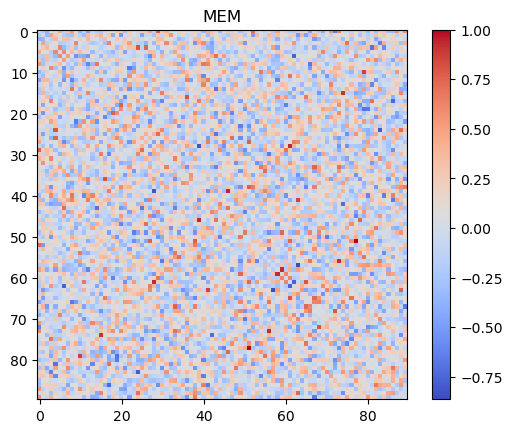

In [141]:
plt.figure()
ax=plt.imshow(correlation_matrix,cmap="coolwarm")
plt.colorbar(ax)
plt.title("Partial correlation")
plt.show()

plt.figure()
ax=plt.imshow(mem_s0[1]/np.abs(mem_s0[1]).max(),cmap="coolwarm")
plt.colorbar(ax)
plt.title("MEM")
plt.show()

In [4]:
#categorize the dataframe based on gender, age and DX
df_info.head()

,SUB_ID,SITE_ID,DX_GROUP,AGE_AT_SCAN,SEX
0,50003,PITT,1,24.45,1
1,50004,PITT,1,19.09,1
2,50005,PITT,1,13.73,2
3,50006,PITT,1,13.37,1
4,50007,PITT,1,17.78,1


In [27]:
#categorizing four age ranges

age_ranges_dict={}
age_ranges_dict["toddler"]=[(6,9),[]]
age_ranges_dict["child"]=[(9,13),[]]
age_ranges_dict["teen"]=[(13,18),[]]
age_ranges_dict["young_adult"]=[(10,60),[]]
age_ranges_dict["middle_age"]=[(40,60),[]]

#site_list=["NYU","SDSU","UM_1","UM_2","USM","YALE"]

df_info_male=df_info
#df_info_male=df_info_male[df_info_male["SITE_ID"].isin(site_list)]

for key in age_ranges_dict.keys():
    age_ranges_dict[key][1]=np.array(df_info_male[(df_info_male["AGE_AT_SCAN"]>
                                                   age_ranges_dict[key][0][0])&
                                                   (df_info_male["AGE_AT_SCAN"]<
                                                    age_ranges_dict[key][0][1])].index)
    


In [7]:
#loading all models

with open("MEM_models_list_aal.pkl","rb") as file:
    models_list=pickle.load(file)
    

In [28]:
dx_age_group_dict=age_ranges_dict.copy()

for key in dx_age_group_dict.keys():
    age_index=age_ranges_dict[key][-1]
    dx_age_group_dict[key]={}
    dx_age_group_dict[key]["healthy"]={}
    dx_age_group_dict[key]["autism"]={}
    dx_age_group_dict[key]["healthy"]["J"]=[]
    dx_age_group_dict[key]["healthy"]["h"]=[]
    dx_age_group_dict[key]["autism"]["J"]=[]
    dx_age_group_dict[key]["autism"]["h"]=[]

    for i in age_index:

        if df_info["DX_GROUP"][i]==1:
            dx_age_group_dict[key]["healthy"]["h"].append(models_list[i][0])
            dx_age_group_dict[key]["healthy"]["J"].append(models_list[i][1][edge_ind])
        else:
            dx_age_group_dict[key]["autism"]["h"].append(models_list[i][0])
            dx_age_group_dict[key]["autism"]["J"].append(models_list[i][1][edge_ind])

In [13]:
len(dx_age_group_dict["middle_age"]["healthy"]["h"])

9

In [9]:
#extracting old subjects
age_index=age_ranges_dict["middle_age"][-1]

ages=[]
for i in age_index:
    if df_info["DX_GROUP"][i]==1:
        ages.append((df_info_male["AGE_AT_SCAN"][i],i))

In [89]:
#plotting box plot for three age ranges with the most number of subjects

#[child, teen, young_adult]

#for child
diff_test_dict={"toddler":{},"child":{},"teen":{}}

for key in diff_test_dict:

    h_p_values=np.empty(num_rois)

    for i in range(num_rois):

        stat,p=mannwhitneyu(np.array(dx_age_group_dict[key]["autism"]["h"])[:,i],
                            np.array(dx_age_group_dict[key]["healthy"]["h"])[:,i])
        h_p_values[i]=p

    h_significant_indices=np.where(h_p_values<0.005)[0]

    diff_test_dict[key]["h"]=h_significant_indices

    J_p_values=np.empty(len(edge_ind[0]))

    for i in range(len(edge_ind[0])):
        stat,p=mannwhitneyu(np.array(dx_age_group_dict[key]["autism"]["J"])[:,i],
                        np.array(dx_age_group_dict[key]["healthy"]["J"])[:,i])
        J_p_values[i]=p

    J_significant_indices=np.where(J_p_values<0.0001)[0] 

    diff_test_dict[key]["J"]=J_significant_indices


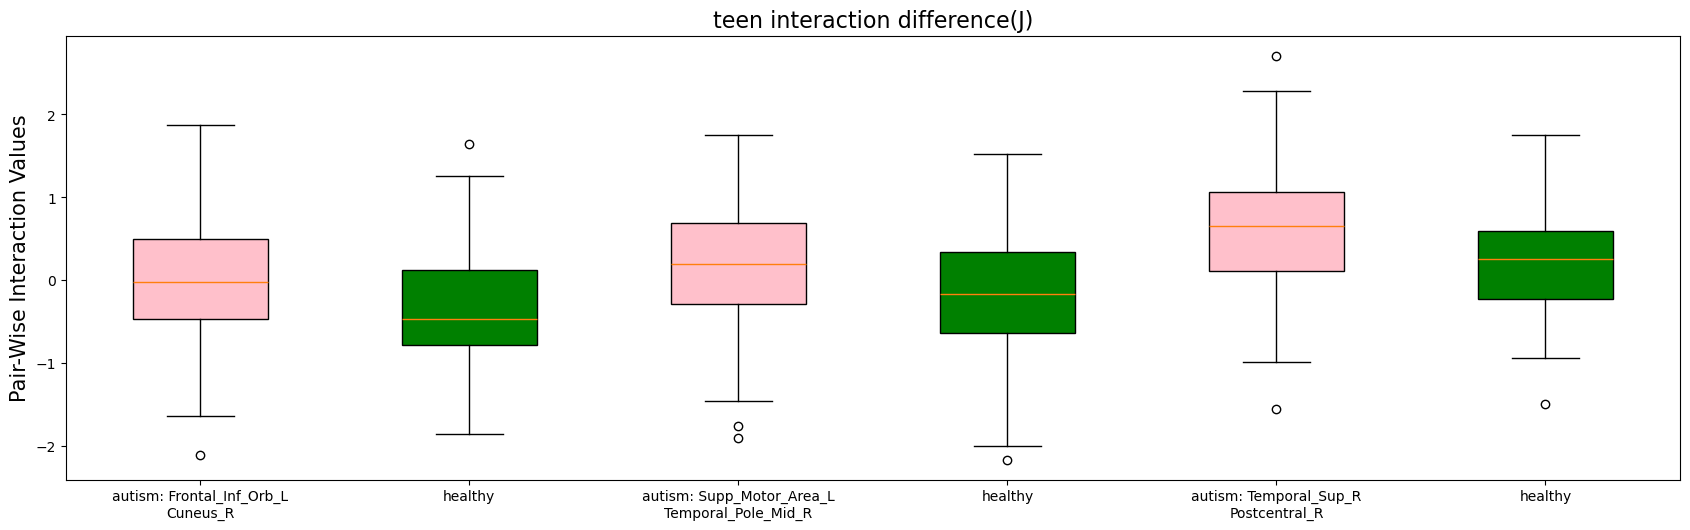

In [ ]:
for key in ["teen"]:

    fig=plt.figure(figsize=(17,10))
   

    ax=fig.add_subplot(2,1,2)
    ax.set_title(key+" interaction difference(J)", fontsize=16)

    J_indices=diff_test_dict[key]["J"]
    data_arr_aut=np.array(dx_age_group_dict[key]["autism"]["J"])[:,J_indices]
    data_arr_hea=np.array(dx_age_group_dict[key]["healthy"]["J"])[:,J_indices]

    data_list=[]
    boxplot_J_labels=[]
    for i,ind in enumerate(J_indices):
        boxplot_J_labels+=["autism: "+labels[edge_ind[0][ind]]+"\n"+labels[edge_ind[1][ind]]]
        boxplot_J_labels+=["healthy"]

        data_list.append(data_arr_aut[:,i])
        data_list.append(data_arr_hea[:,i])

    colors=[]
    for i in range(2*len(J_indices)):
        if i%2==1:
            colors.append("green")
        else:
            colors.append("pink") 

    box=ax.boxplot(data_list,labels=boxplot_J_labels,patch_artist=True)

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel("Pair-Wise Interaction Values",fontsize=15)            
    
    ###
    plt.tight_layout()


In [29]:
#now want to see if there is any difference between ising energies of two groups

def Ising_physical_results(J,h,signal):
    
    #T=1(beta=1)
    averages=signal.mean(axis=0)
    correlations=(signal.T@signal)/signal.shape[0]
    edge_ind=np.triu_indices(signal.shape[-1],k=1)

    averaged_energy=-2*np.sum(J[edge_ind]*correlations[edge_ind])-np.sum(averages*h)

    D=np.diag(1-averages**2)
    covariance_matrix=D@np.linalg.inv(np.identity(signal.shape[-1])-D@J)

    return averaged_energy,covariance_matrix

In [30]:
#adult signals for calculating C

adult_signals=[]
C_list=[]

for i in age_ranges_dict["young_adult"][-1]:
    if df_info["DX_GROUP"][i]==1:

        adult_signals.append(binarized_signals[i])
        J=models_list[i][1]
        h=models_list[i][0]
        C_list.append(Ising_physical_results(J,h,binarized_signals[i])[-1].sum(axis=0))

C_list=np.array(C_list)
C_avg=C_list.mean(axis=0)
C_sem=C_list.std(axis=0)/np.sqrt(len(C_list)-1)




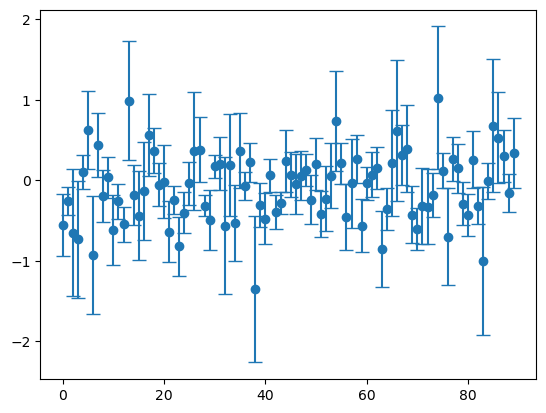

In [35]:
plt.figure()
plt.errorbar(np.arange(90),C_avg,yerr=C_sem,capsize=5,fmt="o")
plt.show()

In [ ]:
### DMN network, a subset of whole network

In [61]:
energy_dict={"teen":{"autism":[],"healthy":[]},"young_adult":{"autism":[],"healthy":[]}}

for key in energy_dict.keys():
    signal_indices=age_ranges_dict[key][1]
    for i in signal_indices:

        if df_info["DX_GROUP"].loc[i]==1:

            energy_dict[key]["healthy"].append(Ising_physical_results(models_list[i][1][mask][:,mask],
                                               models_list[i][0][mask],binarized_signals[i][:,mask])[0])
            
        else:
            energy_dict[key]["autism"].append(Ising_physical_results(models_list[i][1][mask][:,mask],
                                               models_list[i][0][mask],binarized_signals[i][:,mask])[0])    

<Axes: >

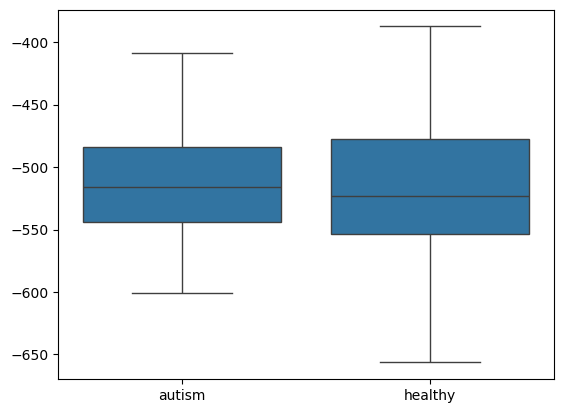

In [62]:
#energy diff among two conditions
key="teen"
labels_box=len(energy_dict[key]["autism"])*["autism"]+len(energy_dict[key]["healthy"])*["healthy"]
sb.boxplot(y=energy_dict[key]["autism"]+energy_dict[key]["healthy"],x=labels_box
           )